In [ ]:
#@markdown términos de uso

tos = """
Copyright (c) 2022, crumb (aicrumb)

1) if you make a derivative of this version, previous versions, or future versions of this notebook, there should be visible acknowledgement that it's a derivative of this notebook, the license as it currently stands should be present un-changed, and idk tag me or something
2) you are not allowed to use outputs from this notebook commercially (you probably already weren't due to some weird copyright laws)
3) 
4) ask your well-to-do friends to sponsor me (aicrumb) (optional)
5) if you are a goblin (including variants such as hob-goblin) or ghoul (mal-aligned spirit without a "normal" physical form (with the exception of cute little squirrel ghouls)) you have to pay a recurring monthly fee of $10 usd after the first image is rendered (this does not prohibit you from having an infinite generation time without paying.) 
"""

# Doohickey V0.1.0 (BETA)
---
by [aicrumb](https://twitter.com/aicrumb) <br>

Wait for the first cell to finish to log in, then you can run the rest. Check out [johnowhitaker](https://twitter.com/johnowhitaker)'s "Grokking Stable Diffusion" to see how sampling from Stable Diffusion works in more detail. It helped a lot in the development of this notebook. <br>
**warning** *messy code ahead, like REALLY messy*

I wanna see what people make! if you use this feel free to tag me

In [1]:
#@title Install required libraries / Log in to the 🤗 hub
import os
from IPython.display import clear_output
import time
if not os.path.exists("installed.txt"):
    # red lines, it's fines, that's what i always say
    !pip install transformers diffusers lpips -q
    # !pip install git+https://github.com/openai/CLIP -q
    !pip install open_clip_torch -q
    !pip install wget -q
    !sudo apt-get install git-lfs
    !cat "test" > installed.txt
    !mkdir /content/output
    print("Installed libraries")
    time.sleep(1) # just so that the user can see a glimpse of the print to know it went succesfuly
    clear_output(wait=False)
else:
    print("Libraries already installed.")

#@markdown Base stable diffusion is "CompVis/stable-diffusion-v1-4". <br>
#@markdown CompVis type (.ckpt files) should be loaded as "user/id/filename" (on huggingface)
model_name = "CompVis/stable-diffusion-v1-4" #@param {"type":"string"}
model_type = "compvis" if ".ckpt" in model_name else "diffusers"

traced = False 
# i'll add some traced models as time goes on, i'm just focused on getting the code working right now

unet_path = None

from huggingface_hub import notebook_login
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


## Setup

In [2]:
#@title Import libraries
import torch
torch.manual_seed(0)
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel
from diffusers import DDIMScheduler, LMSDiscreteScheduler, PNDMScheduler
from IPython.display import Image, display
from tqdm.auto import tqdm, trange
from torch import autocast
import PIL.Image as PImage
import numpy
from torchvision import transforms
import torchvision.transforms.functional as f
import random
import requests
from io import BytesIO

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"
offload_device = "cpu"

In [3]:
#@title Load Models / Enable Attention Slicing

#@markdown <details> attention slicing makes it so that, in pipelines, generating only requries 3.2GB of vram, at a 10% speed decrease <br>
#@markdown reported here: <a href="https://huggingface.co/blog/diffusers-2nd-month#optimizations-for-smaller-gpus">link</a> <br>
#@markdown attention slicing is enabled by default on the traced models <br>
#@markdown `slice_size` integer 1-8

# default behavior
delete_previous_model = True #@param {"type":"boolean"}
if delete_previous_model:
    !rm -r /content/output-model

if model_type == "compvis" and not os.path.exists("/content/output-model"):
    repo_id = "/".join(model_name.split("/")[:2])
    filename = "/".join(model_name.split("/")[2:])

    from huggingface_hub import hf_hub_download
    print("downloading model...")
    compvis_path = hf_hub_download(repo_id=repo_id, filename=filename)
    print("downloading conversion scripts...")
    !pip install OmegaConf -q
    !curl https://raw.githubusercontent.com/huggingface/diffusers/main/scripts/convert_original_stable_diffusion_to_diffusers.py > convert.py
    print("creating diffusers-style model... (this will take a while)")
    !python convert.py --checkpoint_path "$compvis_path" --dump_path "output-model"
else:
    print("Model already downloaded!")

if model_type=="compvis":
    model_name = "output-model"


attention_slicing = True #@param {"type":"boolean"}
# slicing_factor = 12 #@param
vae = AutoencoderKL.from_pretrained(model_name, subfolder="vae", use_auth_token=True)

tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
try:
    text_encoder = CLIPTextModel.from_pretrained(model_name, subfolder="text_encoder", use_auth_token=True)
except:
    print("Text encoder could not be loaded from the repo specified for some reason, falling back to the vit-l repo")
    text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

if unet_path!=None:
    # unet = UNet2DConditionModel.from_pretrained(unet_path)
    from huggingface_hub import hf_hub_download
    model_name = hf_hub_download(repo_id=unet_path, filename="unet.pt")
    unet = torch.jit.load(model_name)
else:
    unet = UNet2DConditionModel.from_pretrained(model_name, subfolder="unet", use_auth_token=True)
    if attention_slicing:
        # slice_size = unet.config.attention_head_dim // slicing_factor
        slice_size = 2 #@param
        unet.set_attention_slice(slice_size)

scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

vae = vae.to(offload_device).half()
text_encoder = text_encoder.to(offload_device).half()
unet = unet.to(torch_device).half()

def requires_grad(model, val=False):
    for param in model.parameters():
        param.requires_grad = val

requires_grad(vae)
requires_grad(text_encoder)
requires_grad(unet)

clear_output(wait=False)


In [4]:
#@title Set up generation loop

to_tensor_tfm = transforms.ToTensor()

# mismatch of tons of image encoding / decoding / loading functions i cant be asked to clean up right now

def pil_to_latent(input_im):
  # Single image -> single latent in a batch (so size 1, 4, 64, 64)
  with torch.no_grad():
      with autocast("cuda"):
        latent = vae.encode(to_tensor_tfm(input_im.convert("RGB")).unsqueeze(0).to(torch_device)*2-1).latent_dist # Note scaling
#   print(latent)
  return 0.18215 * latent.mode() # or .mean or .sample

def latents_to_pil(latents):
  # bath of latents -> list of images
  latents = (1 / 0.18215) * latents
  with torch.no_grad():
    image = vae.decode(latents)
  image = (image / 2 + 0.5).clamp(0, 1)
  image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
  images = (image * 255).round().astype("uint8")
  pil_images = [Image.fromarray(image) for image in images]
  return pil_images

def get_latent_from_url(url, size=(512,512)):
    response = requests.get(url)
    img = PImage.open(BytesIO(response.content))
    img = img.resize(size).convert("RGB")
    latent = pil_to_latent(img)
    return latent

def scale_and_decode(latents):
    with autocast("cuda"):
        # scale and decode the image latents with vae
        latents = 1 / 0.18215 * latents
        with torch.no_grad():
            image = vae.decode(latents).sample.squeeze(0)
        image = f.to_pil_image((image / 2 + 0.5).clamp(0, 1))
        return image

def fetch(url_or_path):
    import io
    if str(url_or_path).startswith('http://') or str(url_or_path).startswith('https://'):
        r = requests.get(url_or_path)
        r.raise_for_status()
        fd = io.BytesIO()
        fd.write(r.content)
        fd.seek(0)
        return PImage.open(fd).convert('RGB')
    return PImage.open(open(url_or_path, 'rb')).convert('RGB')

"""
grabs all text up to the first occurrence of ':' 
uses the grabbed text as a sub-prompt, and takes the value following ':' as weight
if ':' has no value defined, defaults to 1.0
repeats until no text remaining
"""
def split_weighted_subprompts(text, split=":"):
    remaining = len(text)
    prompts = []
    weights = []
    while remaining > 0:
        if split in text:
            idx = text.index(split) # first occurrence from start
            # grab up to index as sub-prompt
            prompt = text[:idx]
            remaining -= idx
            # remove from main text
            text = text[idx+1:]
            # find value for weight 
            if " " in text:
                idx = text.index(" ") # first occurence
            else: # no space, read to end
                idx = len(text)
            if idx != 0:
                try:
                    weight = float(text[:idx])
                except: # couldn't treat as float
                    print(f"Warning: '{text[:idx]}' is not a value, are you missing a space?")
                    weight = 1.0
            else: # no value found
                weight = 1.0
            # remove from main text
            remaining -= idx
            text = text[idx+1:]
            # append the sub-prompt and its weight
            prompts.append(prompt)
            weights.append(weight)
        else: # no : found
            if len(text) > 0: # there is still text though
                # take remainder as weight 1
                prompts.append(text)
                weights.append(1.0)
            remaining = 0
    print(prompts, weights)
    return prompts, weights 


# from some stackoverflow comment
import numpy as np
def lerp(a, b, x):
    "linear interpolation"
    return a + x * (b - a)
def fade(t):
    "6t^5 - 15t^4 + 10t^3"
    return 6 * t**5 - 15 * t**4 + 10 * t**3
def gradient(h, x, y):
    "grad converts h to the right gradient vector and return the dot product with (x,y)"
    vectors = np.array([[0, 1], [0, -1], [1, 0], [-1, 0]])
    g = vectors[h % 4]
    return g[:, :, 0] * x + g[:, :, 1] * y
def perlin(x, y, seed=0):
    # permutation table
    np.random.seed(seed)
    p = np.arange(256, dtype=int)
    np.random.shuffle(p)
    p = np.stack([p, p]).flatten()
    # coordinates of the top-left
    xi, yi = x.astype(int), y.astype(int)
    # internal coordinates
    xf, yf = x - xi, y - yi
    # fade factors
    u, v = fade(xf), fade(yf)
    # noise components
    n00 = gradient(p[p[xi] + yi], xf, yf)
    n01 = gradient(p[p[xi] + yi + 1], xf, yf - 1)
    n11 = gradient(p[p[xi + 1] + yi + 1], xf - 1, yf - 1)
    n10 = gradient(p[p[xi + 1] + yi], xf - 1, yf)
    # combine noises
    x1 = lerp(n00, n10, u)
    x2 = lerp(n01, n11, u)  # FIX1: I was using n10 instead of n01
    return lerp(x1, x2, v)  # FIX2: I also had to reverse x1 and x2 here

clip_model = None
def sample(args):
    global in_channels
    global text_encoder # uugghhhghhghgh
    global vae # UUGHGHHGHGH
    global unet # .hggfkgjks;ldjf
    global clip_model
    # prompt = args.prompt
    prompts, weights = split_weighted_subprompts(args.prompt)
    h,w = args.size
    steps = args.steps
    scale = args.scale
    classifier_guidance = args.classifier_guidance
    use_init = len(args.init_img)>1
    if args.seed!=-1:
        seed = args.seed
        generator = torch.manual_seed(seed)
    else:
        seed = random.randint(0,10_000)
        generator = torch.manual_seed(seed)
    print(f"Generating with seed {seed}...")
    
    # tokenize / encode text
    tokens = [tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt") for prompt in prompts]
    with torch.no_grad():
        # move CLIP to cuda
        text_encoder = text_encoder.to(torch_device)
        text_embeddings = [text_encoder(tok.input_ids.to(torch_device))[0].unsqueeze(0) for tok in tokens]
        text_embeddings = [text_embeddings[i]*weights[i] for i in range(len(text_embeddings))]
        text_embeddings = torch.cat(text_embeddings, 0).sum(0)
        max_length = 77
        uncond_input = tokenizer(
            [""], padding="max_length", max_length=max_length, return_tensors="pt"
        )
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
        text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
        # move it back to CPU so there's more vram for generating
        text_encoder = text_encoder.to(offload_device)
    images = []

    if args.lpips_guidance:
        import lpips
        lpips_model = lpips.LPIPS(net='vgg').to(torch_device)
        init = to_tensor_tfm(fetch(args.init_img).resize(args.size)).to(torch_device)

    for batch_n in trange(args.batches):
        with autocast("cuda"):
            # unet = unet.to(torch_device)
            scheduler.set_timesteps(steps)
            if not use_init or args.start_step==0:
                latents = torch.randn(
                    (1, in_channels, h//8, w//8),
                    generator=generator
                )
                latents = latents.to(torch_device)
                latents = latents * scheduler.sigmas[0]
                start_step = args.start_step
            else:
                # Start step
                start_step = args.start_step -1
                start_sigma = scheduler.sigmas[start_step]
                start_timestep = int(scheduler.timesteps[start_step])

                # Prep latents
                vae = vae.to(torch_device)
                encoded = get_latent_from_url(args.init_img)
                if not classifier_guidance:
                    vae = vae.to(offload_device)

                # ???????????????????????????????????????
                encoded = f.resize(encoded, (h//8,w//8))

                noise = torch.randn_like(encoded)
                sigmas = scheduler.match_shape(scheduler.sigmas[start_step], noise)
                noisy_samples = encoded + noise * sigmas

                latents = noisy_samples.to(torch_device).half()

                
            
            if args.perlin_multi != 0 and args.start_step==0:
                linx = np.linspace(0, 5, h // 8, endpoint=False)
                liny = np.linspace(0, 5, w // 8, endpoint=False)
                x, y = np.meshgrid(liny, linx)
                p = [np.expand_dims(perlin(x, y, seed=i), 0) for i in range(4)] # reproducable seed
                p = np.concatenate(p, 0)
                p = torch.tensor(p).unsqueeze(0).cuda()
                # latents = latents + (p * args.perlin_multi).to(torch_device).half()
                latents = latents*(1-(args.perlin_multi*0.1)) + (p*args.perlin_multi).to(torch_device).half()

            vae = vae.to(offload_device)
            if classifier_guidance and args.clip_scale!=0:
                clip_model = clip_model.to(offload_device)
            for i, t in tqdm(enumerate(scheduler.timesteps), total=steps):
                if i > args.start_step:
                    latent_model_input = torch.cat([latents]*2)
                    sigma = scheduler.sigmas[i]
                    latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)
                    latent_model_input_1, latent_model_input_2 = latent_model_input.chunk(2)
                    if classifier_guidance:
                        latent_model_input_2 = latent_model_input_2.requires_grad_(True)
                    # with torch.no_grad():
                        # noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]
                        # noise_pred = unet(latent_model_input, torch.tensor(t, dtype=torch.float32).cuda().half(), text_embeddings)#["sample"]

                    if traced and model_type!="compvis" and unet_path!=None:
                        with torch.no_grad():
                            noise_pred_uncond = unet(latent_model_input_1, torch.tensor(t, dtype=torch.float32).cuda(), text_embeddings[0].unsqueeze(0))#["sample"]
                        noise_pred_text = unet(latent_model_input_2, torch.tensor(t, dtype=torch.float32).cuda(), text_embeddings[1].unsqueeze(0))#["sample"]
                    else:
                        with torch.no_grad():
                            noise_pred_uncond = unet(latent_model_input_1, t, encoder_hidden_states=text_embeddings[0].unsqueeze(0))["sample"]
                        noise_pred_text = unet(latent_model_input_2, t, encoder_hidden_states=text_embeddings[1].unsqueeze(0))["sample"]
                    # cfg
                    # noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                    noise_pred = noise_pred_uncond + scale * (noise_pred_text - noise_pred_uncond)

                    # cg
                    if classifier_guidance:
                        if vae.device != latents.device and not args.quick_guidance:
                            vae = vae.to(latents.device)
                        # latents = latents.detach().requires_grad_()
                        latents_x0 = latents - sigma * noise_pred

                        if not args.quick_guidance:
                            denoised_images = vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5
                        else:
                            # https://twitter.com/anton_lozhkov/status/1572906509335498752
                            v1_4_rgb_latent_factors = torch.tensor([
                                #   R       G       B
                                [ 0.298,  0.207,  0.208],  # L1
                                [ 0.187,  0.286,  0.173],  # L2
                                [-0.158,  0.189,  0.264],  # L3
                                [-0.184, -0.271, -0.473],  # L4
                            ], device='cuda')
                            denoised_images = (latents_x0[0].permute(1, 2, 0) @ v1_4_rgb_latent_factors).unsqueeze(0).permute(0, 3, 1, 2).add(1).div(2) 

                        if args.clip_scale != 0:
                            loss = args.loss_fn(denoised_images, "clip") * args.clip_scale
                        if args.tv_scale != 0:
                            loss = args.loss_fn(denoised_images, "tv") * args.tv_scale
                        if args.lpips_scale != 0:
                            loss = 0
                            # dude oh my god
                            denoised_images = f.resize(denoised_images, (512,512))
                            init = f.resize(init, (512,512))
                            init_losses = lpips_model(denoised_images, init)
                            loss = loss + init_losses.sum() * args.lpips_scale
                        # why is the latent input not on cuda
                        loss = loss.cuda()
                        latent_model_input_2 = latent_model_input_2.cuda()
                        clip_model.cuda().float()
                        # cond_grad = -torch.autograd.grad(loss, latents)[0]
                        cond_grad = -torch.autograd.grad(loss, latent_model_input_2)[0]
                        cond_grad = torch.nan_to_num(cond_grad)
                        magnitude = cond_grad.square().mean().sqrt()
                        cond_grad = cond_grad * magnitude.clamp(max=args.clamp_max) / magnitude
                        cond_grad = torch.nan_to_num(cond_grad)
                        # print(cond_grad.abs().max())
                        latents = latents.detach() + cond_grad.detach() * sigma**2
                        ######
                        if not args.quick_guidance:
                            vae = vae.to(offload_device)
                        clip_model.to(offload_device).half()
                    latents = scheduler.step(noise_pred, i, latents)["prev_sample"]

        # yaaaaay juggling but guess what it DOESNT WORK!!!!
        vae = vae.to(torch_device).half()
        unet = unet.to(offload_device)
        text_encoder = text_encoder.to(offload_device)

        output_image = scale_and_decode(latents.detach().requires_grad_(False).half())

        vae = vae.to(offload_device)
        unet = unet.to(torch_device)
        text_encoder = text_encoder.to(torch_device)
        images.append(output_image)

        import gc
        gc.collect()
        torch.cuda.empty_cache()

        images[-1].save(f"output/{batch_n}.png")
        display(Image(f"output/{batch_n}.png"))
        if args.notif:
            from google.colab import output
            output.eval_js('new Audio("https://freesound.org/data/previews/80/80921_1022651-lq.ogg").play()')
    return images


In [5]:
#@title load textual-inversion concepts from 🤗 hub

#@markdown `load_full_concepts_library` if turned on will take a While, it loads every single stable diffusion concept on https://huggingface.co/sd-concepts-library <br>
#@markdown `specific_concepts` can be a list of strings, containing the ids of your concepts (from sd-concepts-library or your own repos, example `["sd-concepts-library/my-first-inversion", "sd-concepts-library/my-second-inversion"]` etc.)

load_full_concepts_library = False #@param {"type":"boolean"}

from huggingface_hub import HfApi
import wget
import os
api = HfApi()
def load_learned_embed_in_clip(learned_embeds_path, text_encoder, tokenizer, token=None):
        loaded_learned_embeds = torch.load(learned_embeds_path, map_location="cpu")
        
        # separate token and the embeds
        trained_token = list(loaded_learned_embeds.keys())[0]
        embeds = loaded_learned_embeds[trained_token]

        # cast to dtype of text_encoder
        dtype = text_encoder.get_input_embeddings().weight.dtype
        embeds.to(dtype)

        # add the token in tokenizer
        token = token if token is not None else trained_token
        num_added_tokens = tokenizer.add_tokens(token)
        i = 1
        # while(num_added_tokens == 0):
        #     print(f"The tokenizer already contains the token {token}.")
        #     token = f"{token[:-1]}-{i}>"
        #     print(f"Attempting to add the token {token}.")
        #     num_added_tokens = tokenizer.add_tokens(token)
        #     i+=1
        
        # resize the token embeddings
        text_encoder.resize_token_embeddings(len(tokenizer))
        
        # get the id for the token and assign the embeds
        token_id = tokenizer.convert_tokens_to_ids(token)
        text_encoder.get_input_embeddings().weight.data[token_id] = embeds
        return token


if load_full_concepts_library:
    models_list = api.list_models(author="sd-concepts-library", sort="likes", direction=-1)
    models = []

    print("Setting up the public library")
    for model in models_list:
        model_content = {}
        model_id = model.modelId
        model_content["id"] = model_id
        embeds_url = f"https://huggingface.co/{model_id}/resolve/main/learned_embeds.bin"
        os.makedirs(model_id,exist_ok = True)
        if not os.path.exists(f"{model_id}/learned_embeds.bin"):
            try:
                wget.download(embeds_url, out=model_id)
            except:
                continue
        token_identifier = f"https://huggingface.co/{model_id}/raw/main/token_identifier.txt"
        response = requests.get(token_identifier)
        token_name = response.text
        print(f"added {token_name}")
        concept_type = f"https://huggingface.co/{model_id}/raw/main/type_of_concept.txt"
        response = requests.get(concept_type)
        concept_name = response.text
        model_content["concept_type"] = concept_name
        images = []
        model_content["images"] = images

        learned_token = load_learned_embed_in_clip(f"{model_id}/learned_embeds.bin", text_encoder, tokenizer, token_name)
        model_content["token"] = learned_token
        models.append(model_content)

specific_concepts = ["sd-concepts-library/cat-toy"] #@param

models = []
for model in specific_concepts:
    model_content = {}
    model_content["id"] = model
    embeds_url = f"https://huggingface.co/{model}/resolve/main/learned_embeds.bin"
    os.makedirs(model,exist_ok = True)
    if not os.path.exists(f"{model}/learned_embeds.bin"):
        try:
            wget.download(embeds_url, out=model)
        except:
            continue
    token_identifier = f"https://huggingface.co/{model}/raw/main/token_identifier.txt"
    response = requests.get(token_identifier)
    token_name = response.text
    print(f"added {token_name}")

    concept_type = f"https://huggingface.co/{model}/raw/main/type_of_concept.txt"
    response = requests.get(concept_type)
    concept_name = response.text
    model_content["concept_type"] = concept_name
    images = []
    model_content["images"] = images

    learned_token = load_learned_embed_in_clip(f"{model}/learned_embeds.bin", text_encoder, tokenizer, token_name)
    model_content["token"] = learned_token
    models.append(model_content)



added <cat-toy>


In [6]:
#@title Convert Old Embedding

#@markdown convert original textual-inversion embeds to huggingface-style ones <br> You can run this cell however many times is needed to input all of your inversions.

from IPython.display import FileLink
import torch

input_file = "" #@param {"type":"string"}
placeholder_token = "<my-style>" #@param {"type":"string"}

def convert_and_load(input_file, placeholder_token):
    x = torch.load(input_file, map_location=torch.device('cpu'))

    params_dict = {
        placeholder_token: torch.tensor(list(x['string_to_param'].items())[0][1])
    }
    torch.save(params_dict, "learned_embeds.bin")
    load_learned_embed_in_clip("learned_embeds.bin", text_encoder, tokenizer, placeholder_token)
    print("loaded", placeholder_token)

if input_file != "":
    convert_and_load(input_file, placeholder_token)

In [7]:
#@markdown load a few midjourney styles
import gdown
gdown.download_folder(url="https://drive.google.com/drive/u/9/folders/1whqzuBtiAIo9V12I20I1EVkfE9TLb1hS", quiet=True)

try:
    folder = "/content/midj textual inversion"
    files = [folder+"/"+i for i in os.listdir(folder) if ".pt" in i]
except: # WHY DOES IT SOMETIMES DO THIS AND SOMETIMES DO IT THE OTHER WAY????? IM SO ANGRY
    folder = "/content"
    files = [folder+"/"+i for i in os.listdir(folder) if ".pt" in i]
names = ["<"+i.split("/")[-1].split(".")[0]+">" for i in files]

for i,j in zip(files, names):
    convert_and_load(i,j)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


loaded <midj-anthro>
loaded <midj-strong>
loaded <midj-portrait>


In [8]:
"""
if you have learned_embeds.bin for your concept, you can just uncomment this line (remove the hash sign and space before it), and change "<my-concept>" to be whatever your token is, like "<among-us-imposter>" or whatever you called it
"""

# load_learned_embed_in_clip("learned_embeds.bin", text_encoder, tokenizer, "<my-concept>")


'\nif you have learned_embeds.bin for your concept, you can just uncomment this line (remove the hash sign and space before it), and change "<my-concept>" to be whatever your token is, like "<among-us-imposter>" or whatever you called it\n'

In [9]:
#@markdown trace / tensorrt
tensorrt = traced

in_channels = 4 # for later, since the traced version doesn't have this attribute
for param in unet.parameters():
    param.requires_grad = False

if traced and unet_path==None:
    with torch.no_grad():
        with torch.autocast(torch_device):
            dummy_latent = torch.randn((1,4,512//8,512//8), device='cuda', requires_grad=False, dtype=torch.float16)
            dummy_time = torch.randn((), device='cuda', requires_grad=False, dtype=torch.float32)
            dummy_txt_emb = torch.randn((1,77,768), device='cuda', requires_grad=False, dtype=torch.float16)
            unet = torch.jit.trace(lambda a,b,c:  unet(a,b,c)['sample'], (dummy_latent, dummy_time, dummy_txt_emb))

    unet.save("traced-unet.pt")

    del unet 
    import gc
    gc.collect()
    torch.cuda.empty_cache()
    
    unet_path="yeah theres a unet"
    print("traced")
if tensorrt and traced and unet_path!=None:
    if unet_path=="yeah theres a unet":
        unet = torch.jit.load("traced-unet.pt").eval().to(torch_device)
    else:
        unet.eval().to(torch_device)
    unet.qconfig = torch.ao.quantization.get_default_qconfig('fx2trt')
    torch.ao.quantization.prepare(unet, inplace=True)
    torch.ao.quantization.convert(unet, inplace=True)

## Generate
<p>Explanation for each parameter + Tips<p>
<hr>
Sections:
<details> <summary> <b> 1. General Settings </b> </summary>
<details> <summary> <code> prompt </code> </summary>
    The prompt for your image. Can be just one string or multiple strings, separated by their respective weights. (example: <code>frog:0.5 dog:0.7</code>) The weights control how much the prompt is supposed to be paid attention to. Try to stick around 0.7-1.3 when all weights are added up for "normal" results. <br>
    Another way to weight prompts is to wrap things you want to focus on in parenthesis, and things you want to de-focus with square brackets. (example: <code>[[red]] (frog)</code>)
    Also included are prompt tags for easy prompt design, beginner prompt..alchemists may not have an intuition for how to change something simple (like "red bird") into a prompt that works well. Included are the tags: <br>
    <code>{artstation}</code>: for that "trending on artstation" feel <br>
    <code>{overwatch}</code>: a painterly overwatch-like fanart style <br>
    <code>{ghibli}</code>: like a ghibli movie <br>
    <code>{intricate}</code>: self explanatory. <br> <br>
</details>

<details> <summary> <code> init_img </code> </summary>
    An image to use as a starting point to generate from. There's two ways to use this. One is to set it as a url to the image you want to start from and turn "start_step" so some number below "steps". Another is to set it as a url, but keep start_step at 0 and change these settings: <br>
    <code>
    classifier_guidance = True <br>
    lpips_guidance = True <br>
    lpips_scale = 8 <br>
    loss_scale = 0 <br>
    </code>
    this will push the model to use that sort of pose but not necessarily keep every detail about it, this can give higher fidelity results but at some time cost. (Also it doesn't always .. keep the pose but it still increases fidelity anyway? I don't know how to explain it 100%) (example: <a href="https://twitter.com/aicrumb/status/1571292327871750146">link</a>) <br>
    try using <a href="https://www.pexels.com/">pexels</a> or <a href="https://reference.pictures/free/">reference.pictures</a> for reference poses here
</details>

<details> <summary> <code> size </code> </summary>
    The size should be formatted as <code>[height, width]</code><br>
    around 768 is the highest either will go without putting the machine out of memory. Each number should be a multiple of 64 (448, 512, 576, 640, 704, 768, etc)
</details>

<details> <summary> <code> steps </code> </summary>
    The steps variable is how long the image should take to render. A good jumping off point if you don't know how it works intuitively yet would be 50-75 (my personal favorite being 65) <br>
    The only way to really know how it effects the generation is to try it.
</details>

<details> <summary> <code> start_step </code> </summary>
    Like said in the <code>init_img</code> section, <code>start_step</code> should be a number below whatever you set <code>steps</code> to. It just skips that far into the generation and should be used when you have an <code>init_img</code> set.
</details>

<details> <summary> <code> perlin_multi </code> </summary>
    This variable adds perlin noise to the starting point of generation. It can help the model latch onto bigger shapes and can make things a little more coherent when using larger sizes than 512x512. Good starting points are anywhere from 0-0.72. (<a href="https://twitter.com/aicrumb/status/1562268451078537216">example</a>)
</details>

<details> <summary> <code> scale </code> </summary>
    The 'Classifier Free Guidance Scale'. It tries to push the image more into the prompt's direction. A good value is 7.5. Lower lets the model imagine more details and higher forces it to adhere to the prompt more strictly, but it doesn't always work.
</details>

<details> <summary> <code> seed </code> </summary>
    For creating re-producable results. Set to -1 for a random seed. (The seed will be printed out at the beginning of generation so if you end up liking one of the results and want to change the settings a little to run it again and see how that effects it, you can put the seed to whatever is printed before generation.)
</details>

<details> <summary> <code> batches </code> </summary>
    This controls how many images it makes.
</details>
</details>

<!--                    -->

<details> <summary> <b> 2. Classifier Guidance </b> </summary>
<details> <summary> <code> lpips_scale </code> </summary>
    Perceptual loss to <code>init_img</code>. Pushes the image to be structurally similar to the <code>init_img</code>. If 0 the lpips model will not be loaded, and the generation time will be faster. See the <code>init_img</code> documentation for tricks with this.
</details>

<details> <summary> <code> clip_scale </code> </summary>
    CLIP similarity to <code>clip_text_prompt</code> and <code>clip_image_prompt</code>. If 0 the CLIP model will not be loaded, and the generation time will be faster. I recommend a max of 0.2 and an average around 0.1. CLIP guidance is NOT DETERMINISTIC! Outputs are not 100% reproducible.
</details>

<details> <summary> <code> tv_scale </code> </summary>
    Total variance loss. Higher makes the image smoother. Doesn't work wonderfully
</details>

<details> <summary> <code> clamp_max </code> </summary>
    Applied in this formula to the gradient <br>
    <code>
    magnitude = cond_grad.square().mean().sqrt()<br>
    cond_grad = cond_grad * magnitude.clamp(max=args.clamp_max) / magnitude
    </code>
</details>

<details> <summary> <code> quick_guidance </code> </summary>
    not great for clip guidance, guiding on this <a href="https://twitter.com/anton_lozhkov/status/1572906509335498752"> twitter post </a> instead of decoding with the vae
</details>

<details> <summary> <code> clip_text_prompt </code> </summary>
    The prompt for CLIP to push the image towards. Has the same weighting scheme as <code>prompt</code>.
</details>

<details> <summary> <code> clip_image_prompt </code> </summary>
    Image urls for CLIP to push the generated image towards. Instead of denoting image weights with :weight like in <code>clip_text_prompt</code> and <code>prompt</code>, it should be denoted with a vertical bar. (url|weight)
</details>

<details> <summary> <code> clip_model_name </code> and <code> clip_model_pretrained </code> </summary>
    The CLIP model to load assuming <code>clip_scale</code> isn't equal to 0. <br>
    Current models that can be loaded are: <br>
    <code>[('ViT-B-32', 'openai'), <br>
    ('ViT-B-32', 'laion400m_e31'),  <br>
    ('ViT-B-32', 'laion400m_e32'), <br>
    ('ViT-B-32', 'laion2b_e16'), <br>
    ('ViT-B-32', 'laion2b_s34b_b79k'),  <br>
    ('ViT-B-32-quickgelu', 'openai'), <br>
    ('ViT-B-32-quickgelu', 'laion400m_e31'),  <br>
    ('ViT-B-32-quickgelu', 'laion400m_e32'), <br>
    ('ViT-B-16', 'openai'), <br>
    ('ViT-B-16', 'laion400m_e31'), <br>
    ('ViT-B-16', 'laion400m_e32'), <br>
    ('ViT-B-16-plus-240', 'laion400m_e31'), <br>
    ('ViT-B-16-plus-240', 'laion400m_e32'), <br>
    ('ViT-L-14', 'openai'), <br>
    ('ViT-L-14', 'laion400m_e31'), <br>
    ('ViT-L-14', 'laion400m_e32'), <br>
    ('ViT-L-14', 'laion2b_s32b_b82k'), <br>
    ('ViT-L-14-336', 'openai'), <br>
    ('ViT-H-14', 'laion2b_s32b_b79k'), <br>
    ('ViT-g-14', 'laion2b_s12b_b42k')] <br></code>
    <p>I would suggest either <code> 'ViT-L-14', 'laion2b_s32b_b82k' </code> or <code> 'ViT-B-32', 'laion2b_s34b_b79k' </code></p>
</details>

<details> <summary> <code> cutn </code> </summary>
    How many permutations of the image to show to CLIP to base the scoring off of. If using large models (vit-h, vit-l) cutn should be as low as 1-3 to avoid going out of memory. Smaller ones (vit-b) can be around 8 for optimal performance, though.
</details>
</details>

Downloading:   0%|          | 0.00/605M [00:00<?, ?B/s]

['Professional HDR photo of a polar bear holding a lollipop on a rooftop in Hong Kong looking up at a UFO in the night sky. A UFO flies above the polar bear. The polar bear holds a lollipop on a rooftop. The background shows Hong Kong.'] [1.0]
['Professional HDR photo of a polar bear holding a lollipop on a rooftop in Hong Kong looking up at a UFO in the night sky. A UFO flies above the polar bear. The polar bear holds a lollipop on a rooftop. The background shows Hong Kong.'] [1.0]
Generating with seed 1...


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

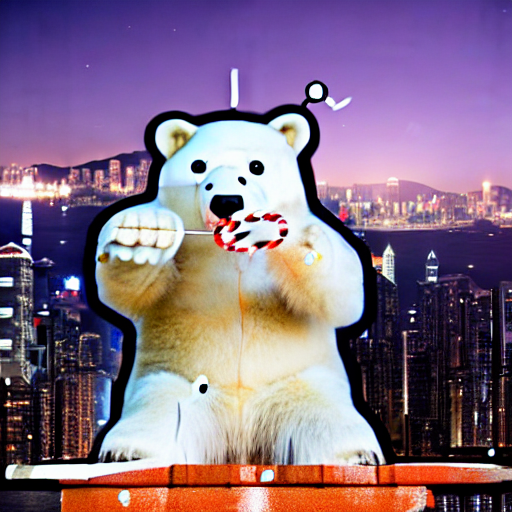

  0%|          | 0/64 [00:00<?, ?it/s]

Interrupting generation..
Done!


In [10]:
#@markdown ---

# idk how people normally do this and i cba to look
prompt = "Professional HDR photo of a polar bear holding a lollipop on a rooftop in Hong Kong looking up at a UFO in the night sky. A UFO flies above the polar bear. The polar bear holds a lollipop on a rooftop. The background shows Hong Kong." #@param {"type":"string"}
bracket_base = 0.05
bracket_multiplier = 1.5
init_img = "" #@param {"type":"string"}
size = [512, 512] #@param
steps = 64 #@param
start_step = 0 #@param
perlin_multi = 0.78 #@param
scale = 7 #@param
seed = 1 #@param
batches = 2 #@param

# a few "styles" from prompts i      stole      from lexica that I know work well, for easy prompt building if you don't have an idea of what to do to improve your prompt
prompt_suffix_map = {
    "{artstation}": "by ross tran, greg rutkowski, trending on artstation, photograph, hyperreal, octane render, oil on canvas",
    "{overwatch}": "from overwatch, character portrait, close up, concept art, intricate details, highly detailed photorealistic in the style of marco plouffe, keos masons, joel torres, seseon yoon, artgerm and warren louw",
    "{ghibli}": "still from studio ghibli movie; very detailed, focused, colorful, antoine pierre mongin, trending on artstation, 8 k",
    "{intricate}": "4 k resolution, trending on artstation, very very detailed, masterpiece, stunning, intricate"
}
def add_suffixes(prompt):
    for i in prompt_suffix_map.keys():
        prompt = prompt.replace(i,prompt_suffix_map[i])
    return prompt
prompt = add_suffixes(prompt)


def count(string, start="(", end=")", negative=True):
    temp_string = ""
    temp_multiplier = bracket_base
    mode = "neutral"
    extension = ""
    for char in string:
        if char == start and mode == "neutral":
            mode = "writing"
            temp_multiplier = bracket_base if not negative else -bracket_base
        if char == start and mode == "writing":
            temp_multiplier *= bracket_multiplier
        if char == end and mode == "writing":
            extension += f" {temp_string}:{str(temp_multiplier)}"
            mode = "neutral"
            temp_multiplier = bracket_base if not negative else -bracket_base
            temp_string = ""
        if char not in [start, end] and mode == "writing":
            temp_string += char
    for char in [start, end]:
        string = string.replace(char, "")
    return string, extension

def add_brackets(prompt):
    if ":" not in prompt[-5:]:
        prompt += ":1"
    clean, ext_p = count(prompt, start="(", end=")", negative=False)
    clean, ext_n = count(clean, start="[", end="]", negative=True)
    return prompt + ext_p + ext_n #  make it work more like automatics so the prompts are more cross-compatible

prompt = add_brackets(prompt)

#@markdown ---

# classifier_guidance = True #@param {"type":"boolean"}
# lpips_guidance = True #@param {"type":"boolean"}
lpips_scale = 0. #@param
clip_scale = 0.1 #@param
tv_scale = 0. #@param
clamp_max = 0.01 #@param
quick_guidance = True #@param {"type":"boolean"}
classifier_guidance = (lpips_scale!=0) or (clip_scale!=0) or (tv_scale!=0)
lpips_guidance = lpips_scale!=0


class BlankClass():
    def __init__(self):
        bruh = 'BRUH'
args = BlankClass()
args.prompt = prompt
args.init_img = init_img
args.size = size 
args.steps = steps 
args.start_step = start_step 
args.scale = scale
args.perlin_multi = perlin_multi
args.seed = seed
args.batches = batches 
args.classifier_guidance = classifier_guidance
args.lpips_guidance = lpips_guidance
args.lpips_scale = lpips_scale
# args.loss_scale = clip_scale
args.clip_scale = clip_scale
args.tv_scale = tv_scale
args.clamp_max = clamp_max
args.quick_guidance = quick_guidance

if args.classifier_guidance:
    # import clip
    import open_clip as clip
    from torch import nn
    import torch.nn.functional as F
    import io

    class MakeCutouts(nn.Module):
        def __init__(self, cut_size, cutn, cut_pow=1.):
            super().__init__()
            self.cut_size = cut_size
            self.cutn = cutn
            self.cut_pow = cut_pow

        def forward(self, input):
            sideY, sideX = input.shape[2:4]
            max_size = min(sideX, sideY)
            min_size = min(sideX, sideY, self.cut_size)
            cutouts = []
            for _ in range(self.cutn):
                size = int(torch.rand([])**self.cut_pow * (max_size - min_size) + min_size)
                offsetx = torch.randint(0, sideX - size + 1, ())
                offsety = torch.randint(0, sideY - size + 1, ())
                cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
                cutouts.append(F.adaptive_avg_pool2d(cutout, self.cut_size))
            return torch.cat(cutouts)
    # make_cutouts = MakeCutouts(224, 16)
    
    clip_text_prompt = "Professional HDR photo of a polar bear holding a lollipop on a rooftop in Hong Kong looking up at a UFO in the night sky. A UFO flies above the polar bear. The polar bear holds a lollipop on a rooftop. The background shows Hong Kong." #@param {"type":"string"}
    if clip_scale != 0:
        clip_text_prompt = add_suffixes(clip_text_prompt)
        clip_text_prompt = add_brackets(clip_text_prompt)

    clip_image_prompt = "" #@param {"type":"string"}

    if clip_scale != 0:
        # clip_model = clip.load("ViT-B/32", jit=False)[0].eval().requires_grad_(False).to(torch_device)
        clip_model_name = "ViT-B-32" #@param {"type":"string"}
        clip_model_pretrained = "laion2b_s34b_b79k" #@param {"type":"string"}
        clip_model, _, preprocess = clip.create_model_and_transforms(clip_model_name, pretrained=clip_model_pretrained)
        clip_model = clip_model.eval().requires_grad_(False).to(torch_device)

        cutn = 1 #@param
        make_cutouts = MakeCutouts(clip_model.visual.image_size if type(clip_model.visual.image_size)!= tuple else clip_model.visual.image_size[0], cutn)

    target = None
    if len(clip_text_prompt) > 1 and clip_scale != 0:
        clip_text_prompt, clip_text_weights = split_weighted_subprompts(clip_text_prompt)
        target = clip_model.encode_text(clip.tokenize(clip_text_prompt).to(torch_device)) * torch.tensor(clip_text_weights).view(len(clip_text_prompt), 1).to(torch_device)
    if len(clip_image_prompt) > 1 and clip_scale != 0:
        clip_image_prompt, clip_image_weights = split_weighted_subprompts(clip_image_prompt, split="|")
        # pesky spaces
        clip_image_prompt = [p.replace(" ", "") for p in clip_image_prompt]
        images = [fetch(image) for image in clip_image_prompt]
        images = [f.to_tensor(i).unsqueeze(0) for i in images]
        images = [make_cutouts(i) for i in images]
        encodings = [clip_model.encode_image(i.to(torch_device)).mean(0) for i in images]
        
        for i in range(len(encodings)):
            encodings[i] = (encodings[i] * clip_image_weights[i]).unsqueeze(0)
        # print(encodings.shape)
        encodings = torch.cat(encodings, 0)
        encoding = encodings.sum(0)

        if target!=None:
            target = target + encoding
        else:
            target = encoding
        target = target.half().to(torch_device)

    # free a little memory, we dont use the text encoder after this so just delete it
    if clip_scale != 0:
        clip_model.transformer = None
    import gc
    gc.collect()
    torch.cuda.empty_cache()
    def spherical_distance(x, y):
        x = F.normalize(x, dim=-1)
        y = F.normalize(y, dim=-1)
        l = (x - y).norm(dim=-1).div(2).arcsin().pow(2).mul(2).mean()
        return l 
    def tv_loss(input):
        input = F.pad(input, (0, 1, 0, 1), 'replicate')
        return ((input[..., :-1, 1:] - input[..., :-1, :-1])**2 + (input[..., 1:, :-1] - input[..., :-1, :-1])**2).mean()
    def loss_fn(x,mode):
        global clip_model
        # crappy way of handling it, i know
        if mode=="clip":
            with torch.autocast("cuda"):
                cutouts = make_cutouts(x)
                # oh my god there's something that requires clip to be at full precision
                clip_model = clip_model.float().cuda()
                encoding = clip_model.encode_image(cutouts.float().cuda()).half()
                clip_model = clip_model.half().cpu()
                loss = spherical_distance(encoding, target)
                return loss.mean().cuda()
        if mode=="tv":
            return tv_loss(x).mean()

    args.loss_fn = loss_fn
#@markdown ---
notify_me_on_every_image = True #@param {"type":"boolean"}
args.notif = notify_me_on_every_image
dtype = torch.float16

try:
    with torch.amp.autocast(device_type=torch_device, dtype=dtype):
        output = sample(args)
except KeyboardInterrupt:
    print('Interrupting generation..')
else:
    print('No errors caught!')
print("Done!")

In [11]:
#@markdown 🔔
from google.colab import output
output.eval_js('new Audio("https://freesound.org/data/previews/80/80921_1022651-lq.ogg").play()')

### Post-Processing

mkdir: cannot create directory ‘flavor’: File exists
Using 'sakura' flavor


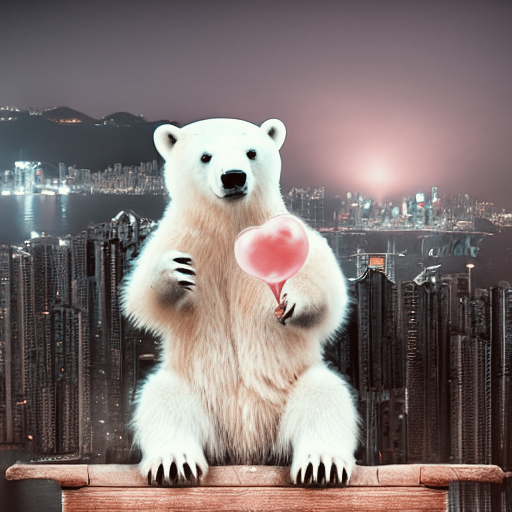

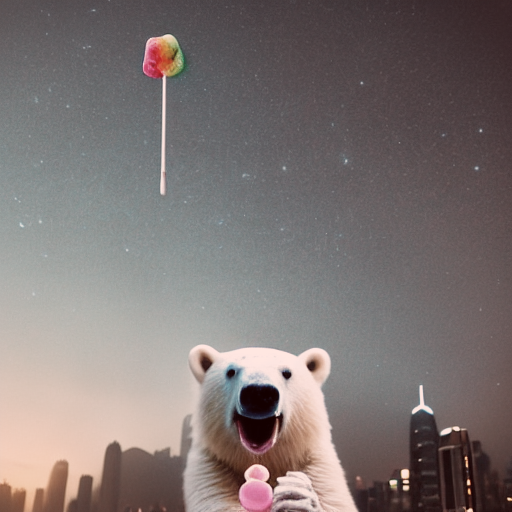

In [ ]:
#@markdown ### Flavor your image
# LOL this is no different than the cell below for matching
!pip install color-matcher -q
!mkdir flavor
from color_matcher import ColorMatcher
from color_matcher.io_handler import load_img_file, save_img_file, FILE_EXTS
from color_matcher.normalizer import Normalizer


color_map = {
    "dust": "https://onecms-res.cloudinary.com/image/upload/s--z1xo9sBq--/c_fill%2Cg_auto%2Ch_676%2Cw_1200/f_auto%2Cq_auto/v1/mediacorp/tdy/image/2022/09/07/20220907_nyt_aiart.jpg?itok=8LHesjBa",
    "jungle": "https://medialist.info/wp-content/uploads/2022/06/2022_06_02_medialist_midjourney.jpg",
    "muddy-gold": "https://miro.medium.com/max/1200/1*XoVCoIeNJ16PYOmWKOs0mg.png",
    "diamond": "https://i.pinimg.com/564x/b7/b3/6a/b7b36a7efdce4e9c53bbbb2c8fbe5c30.jpg",
    "rose": "https://i.pinimg.com/564x/21/60/d5/2160d5efafff9b910859e2657268aaa2.jpg",
    "deep-ocean": "https://i.pinimg.com/564x/93/1c/8b/931c8b2b184ba175686ebe815cec22b0.jpg",
    "yellow": "https://i.pinimg.com/564x/62/ba/d7/62bad7f5cbc3740c149c16b3f2aedf3d.jpg",
    "sakura": "https://i.pinimg.com/564x/aa/a5/fa/aaa5fa9feaf11434187f6c11e8b9fa3b.jpg"
}

flavor = "sakura" #@param ['deep-ocean', 'diamond', 'dust', 'jungle', 'muddy-gold', 'random', 'rose', 'sakura', 'yellow']
if flavor!="random":
    print(f"Using '{flavor}' flavor")
    flavor = color_map[flavor]
else:
    import random
    flavor = random.choice(list(color_map.keys()))
    print(f"Using '{flavor}' flavor")
    flavor = color_map[flavor]
reference_image = fetch(flavor)
reference_image.save("ref.png")

img_ref = load_img_file('ref.png')

src_path = '/content/output'
filenames = [os.path.join(src_path, f) for f in os.listdir(src_path)
                     if f.lower().endswith(FILE_EXTS)]

cm = ColorMatcher()
for i, fname in enumerate(filenames):
    img_src = load_img_file(fname) * 0.95
    # ('default', 'hm', 'reinhard', 'mvgd', 'mkl', 'hm-mvgd-hm', 'hm-mkl-hm')
    img_res = cm.transfer(src=img_src, ref=img_ref, method='mkl')
    img_res = Normalizer(img_res).uint8_norm()
    save_img_file(img_res, os.path.join(f'flavor/{i}.png'))
    display(Image(f'flavor/{i}.png'))

mkdir: cannot create directory ‘correct-output’: File exists
rm: cannot remove '/content/output/.ipynb_checkpoints': No such file or directory


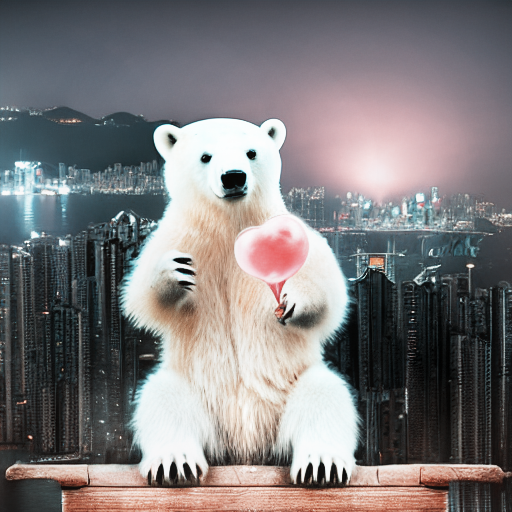

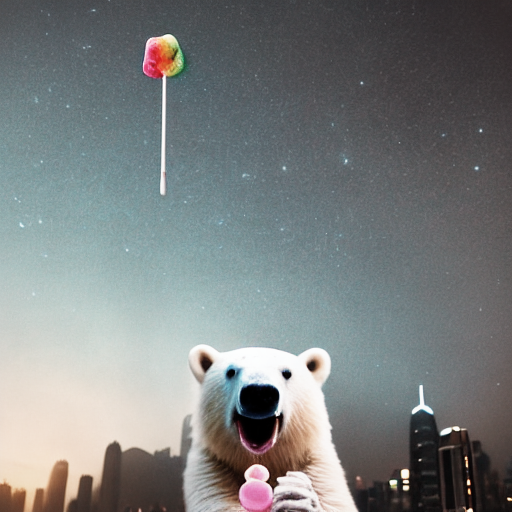

In [ ]:
#@markdown ### Color Correction
!pip install git+https://github.com/shunsukeaihara/colorcorrect.git -q
# via https://github.com/shunsukeaihara/colorcorrect
!mkdir correct-output

# why does it do this
!rm -r /content/output/.ipynb_checkpoints
import colorcorrect.algorithm as cca
from colorcorrect.util import from_pil, to_pil
from colorcorrect.algorithm import *
algorithm = automatic_color_equalization #@param ["grey_world", "max_white", "retinex", "retinex_with_adjust", "standard_deviation_weighted_grey_world", "standard_deviation_and_luminance_weighted_grey_world", "luminance_weighted_grey_world", "automatic_color_equalization"] {type:"raw"}

folders_map = {
    "raw": "/content/output",
    "flavored": "/content/flavor"
}

folder = "flavored" #@param ["raw", "flavored"]

src_path = folders_map[folder]
filenames = [os.path.join(src_path, f) for f in os.listdir(src_path)]

for i, fname in enumerate(filenames):
    image = PImage.open(fname)
    to_pil(algorithm(from_pil(image))).save(f'correct-output/{i}.png')
    display(Image(f'correct-output/{i}.png'))

####################
Reference image


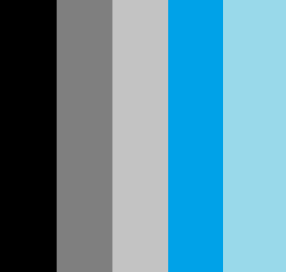


####################
Color Matched outputs


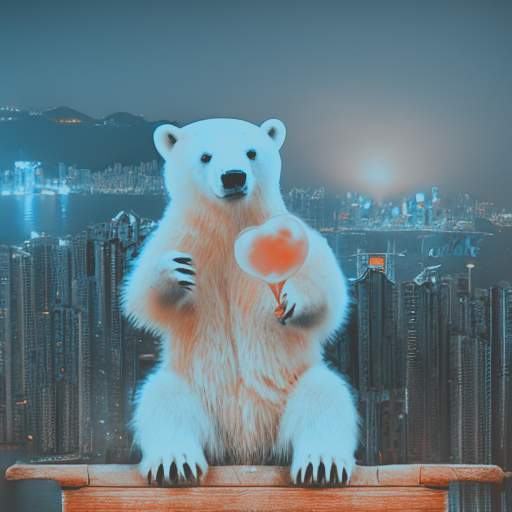

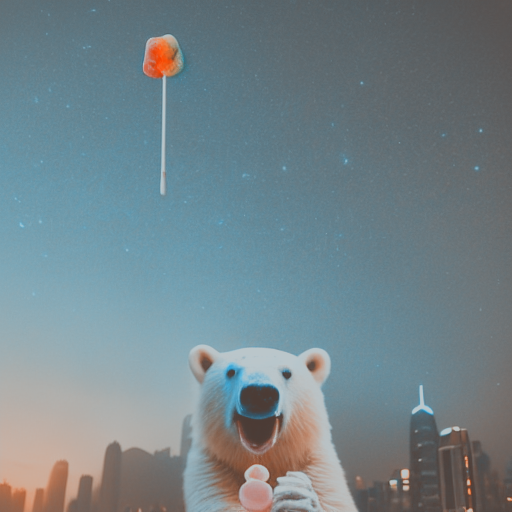

In [ ]:
#@markdown ### Match colors to a reference image
#@markdown fun tip: you can use https://colorhunt.co/ to find a color palette to match your image to, download the palette as an image, upload it to colab, set reference_url to the file path
# !pip install color-matcher -q
!mkdir color-output
from color_matcher import ColorMatcher
from color_matcher.io_handler import load_img_file, save_img_file, FILE_EXTS
from color_matcher.normalizer import Normalizer

reference_url = "https://media.discordapp.net/attachments/1012719433745186976/1021101572953997423/unknown.png?width=286&height=272" #@param {"type":"string"}
reference_image = fetch(reference_url)
reference_image.save("ref.png")

img_ref = load_img_file('ref.png')

print("#"*20)
print("Reference image")
display(Image("ref.png"))
print("\n" + "#"*20)
print("Color Matched outputs")

src_path = '/content/output'
filenames = [os.path.join(src_path, f) for f in os.listdir(src_path)
                     if f.lower().endswith(FILE_EXTS)]

cm = ColorMatcher()
for i, fname in enumerate(filenames):
    img_src = load_img_file(fname) * 0.95
    # ('default', 'hm', 'reinhard', 'mvgd', 'mkl', 'hm-mvgd-hm', 'hm-mkl-hm')
    img_res = cm.transfer(src=img_src, ref=img_ref, method='mkl')
    img_res = Normalizer(img_res).uint8_norm()
    save_img_file(img_res, os.path.join(f'color-output/{i}.png'))
    display(Image(f'color-output/{i}.png'))

In [ ]:
#@markdown 🔔
from google.colab import output
output.eval_js('new Audio("https://freesound.org/data/previews/80/80921_1022651-lq.ogg").play()')